In [30]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [31]:
def format_plot1(ax, title=None):
    if title is not None:
        ax.set_title(title)
    ax.grid()
    ax.set_xlabel("Filter size")
    ax.set_ylabel("Runtime (s)")

    ax.set_xticks([8,16,32,64,128,256])
    return ax


# Point 1: Loop efficiency analysis

Each experimental condition was run for 10 iterations. The following plots show the mean and 95% confidence interval for each filter size and condition.

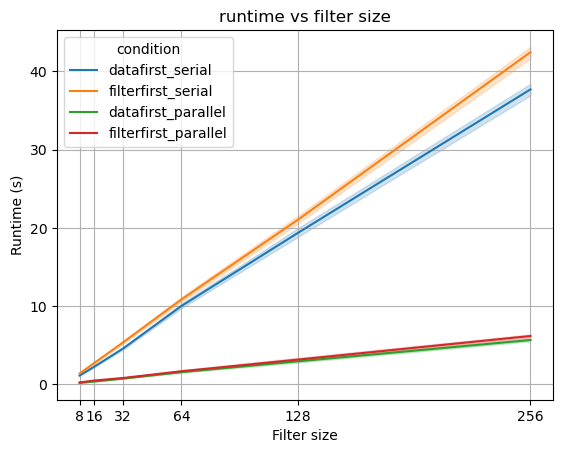

In [32]:
# Complete
exp_df = pd.read_csv("./results/experiment1_final2.csv")
exp_df["condition"] = exp_df['type'].astype(str) +"_"+ exp_df["exec_type"]
exp_df["norm_time"] = exp_df["time"]/exp_df["filter_size"]

fig,ax = plt.subplots(1,1)
sns.lineplot(data=exp_df, x="filter_size", y="time", hue="condition", ax=ax)
ax = format_plot1(ax, title="runtime vs filter size")
plt.show()


## Run time performance Analysis

In [33]:
filtered_df = exp_df.loc[exp_df["exec_type"]=="serial"]
filtered_df.head()

,run,time,filter_size,type,exec_type,threads,condition,norm_time
0,0,1.204174,8,datafirst,serial,1,datafirst_serial,0.150522
1,0,1.434980,8,filterfirst,serial,1,filterfirst_serial,0.179372
4,0,2.166667,16,datafirst,serial,1,datafirst_serial,0.135417
5,0,2.569019,16,filterfirst,serial,1,filterfirst_serial,0.160564
8,0,4.367055,32,datafirst,serial,1,datafirst_serial,0.136470


## Analysis

**b. Does the runtime improve or degrade as the filter grows in size? Why? Hint: A filter of size 8 does twice as much work as a filter of size 4. So, divide the performance by the filter length to get a sense of efficiency.**

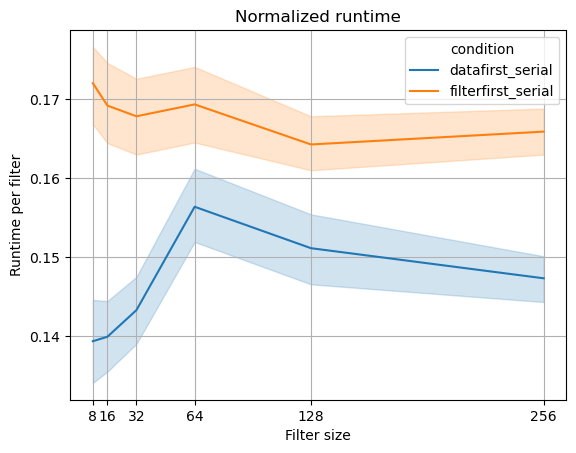

In [34]:
filtered_df = exp_df.loc[exp_df["exec_type"]=="serial"]
filtered_df.head()

fig,ax = plt.subplots(1,1)
sns.lineplot(data=filtered_df, x="filter_size", y="norm_time", hue="condition", ax=ax)
ax = format_plot1(ax, title="Normalized runtime")
ax.set_ylabel("Runtime per filter")
plt.show()


**c. In what cases, if any, is serialFilterFirst faster? Explain why. Hint: This will be a function of the loop sizes and caching effects in the memory system.** 

**d. In what cases, if any, is serialDataFirst faster? Explain why.**


# Point 2: Parallel loop


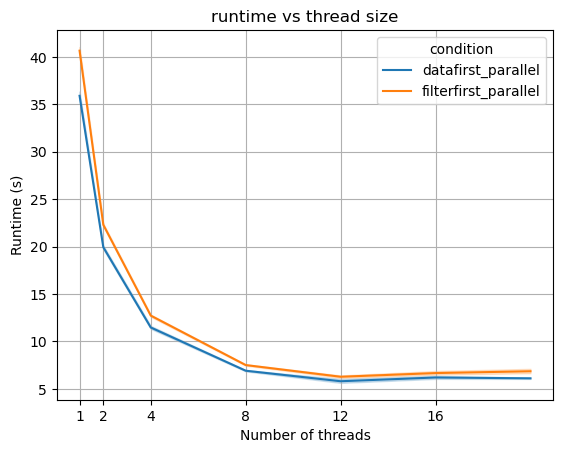

In [35]:
def format_plot2(ax, title=None):
    if title is not None:
        ax.set_title(title)
    ax.grid()
    ax.set_xlabel("Number of threads")
    ax.set_ylabel("Runtime (s)")

    ax.set_xticks([1,2,4,8,12,16])
    return ax

# Complete
exp_df = pd.read_csv("./results/experiment2_final1.csv")
exp_df["condition"] = exp_df['type'].astype(str) +"_"+ exp_df["exec_type"]
exp_df["norm_time"] = exp_df["time"]/exp_df["filter_size"]

fig,ax = plt.subplots(1,1)
sns.lineplot(data=exp_df, x="threads", y="time", hue="condition", ax=ax)
ax = format_plot2(ax, title="runtime vs thread size")
plt.show()

## Analysis

**a. Generate speedup plots for 1,2,4,8, and 16 threads. You will have to specify the number of threads to run using omp_set_num_threads() or the OMP_NUM_THREADS environment variable.**

Mean serial performance 38.2731033


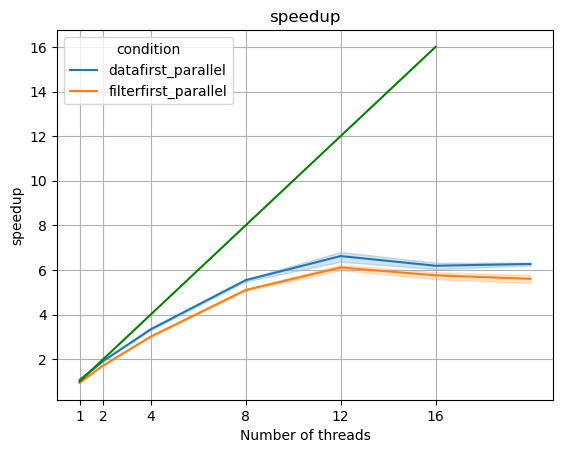

In [36]:
# Complete
exp_df = pd.read_csv("./results/experiment2_final1.csv")
exp_df["condition"] = exp_df['type'].astype(str) +"_"+ exp_df["exec_type"]
mean_serial_performance = exp_df.loc[ exp_df["threads"] == 1]["time"].mean()
print(f"Mean serial performance {mean_serial_performance}")
exp_df["speedup"] = mean_serial_performance/exp_df['time']

fig,ax = plt.subplots(1,1)
sns.lineplot(data=exp_df, x="threads", y="speedup", hue="condition", ax=ax)
ax = format_plot2(ax, title="speedup")
ax.set_ylabel("speedup")
ax.plot([1,16],[1,16], label="ideal speedup", color='green')
plt.show()


**b. At what level of parallelism did speedup stop increasing? Explain.**

The speedup stop increasing after 12 threads. This is because the experiments were ran in a PC with a total of 12 parallel resources.

**c. Estimate the Amhdahl number p for both functions. Show your work.**

$$\text{amdahl number} = \frac{processors}{processors-1}*(1-1/speedup)$$


In [37]:
import numpy as np
np.set_printoptions(precision=4)

for condition in ["datafirst_parallel","filterfirst_parallel"]:
    processors = [2,4,8,12,16]
    speedup_list = []
    for threads in processors: 
        speedup = exp_df.loc[(exp_df['threads']==threads) & (exp_df['condition']==condition)]['speedup'].mean()
        speedup_list.append(speedup)

    processors = np.array(processors)
    speedup = np.array(speedup_list)
    amdahl_number = processors/(processors-1)*(1-1/speedup)
    print(f"Amdal number for {condition:25s}:   {amdahl_number}")

Amdal number for datafirst_parallel       :   [0.9588 0.934  0.9366 0.9262 0.8943]
Amdal number for filterfirst_parallel     :   [0.8353 0.8903 0.9187 0.9123 0.8814]


**d. Which function is faster? Why?**

Data first function is faster.

**e. Which function is more scalable? Why?**

**d. To what factors against parallelism (startup, interference, skew) do you attribute the loss of parallel efficiency? Explain.**

# Point 3: Loop unrolling


['DFUF' 'FFUF' 'DFUD' 'FFUD']


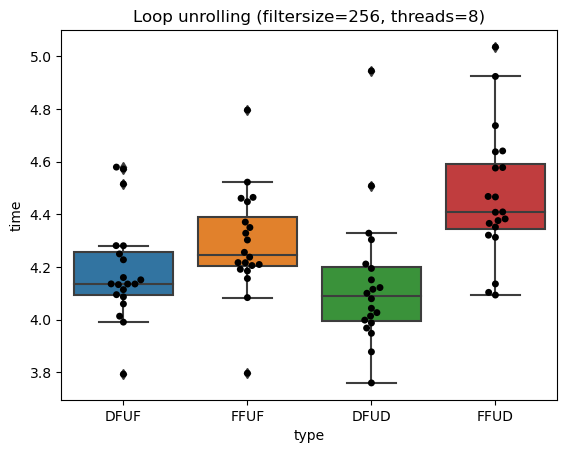

Mean
type
DFUD    4.134137
DFUF    4.185418
FFUD    4.465870
FFUF    4.289737
Name: time, dtype: float64
Std
type
DFUD    0.253319
DFUF    0.193207
FFUD    0.246970
FFUF    0.199800
Name: time, dtype: float64


In [47]:
exp3_df = pd.read_csv("./results/experiment3_final2.csv")

print(exp3_df['type'].unique())
fig, ax = plt.subplots(1,1)
ax.set_title("Loop unrolling (filtersize=256, threads=8)")
sns.boxplot(data=exp3_df,y='time',x='type')
sns.swarmplot(data=exp3_df,y='time',x='type',color='black')
plt.show()

print("Mean")
print(exp3_df.groupby('type')['time'].mean())
print("Std")
print(exp3_df.groupby('type')['time'].std())


## Analysis

**a. Is it more efficient to unroll the outer loop or the inner loop? Explain why.**

From the performed experiments it is not possible to conclude which loop is better to unroll.

**b. What operations/instructions are eliminated by loop unrolling? How many instructions per loop?**

Eliminate instructions related to the conditional logic of the for loop. This instructions are a comparison to identify if the loop needs to end and an update of the for loop variable.
Since the for loop is unrolled by a factor of 8, we are saving 16 operations per each loop by unrolling.


**c. Which combination of loop unrolling and iteration order is the most efficient? Explain why. If this is a different loop order than was found in parts 1 or 2, explain the difference.**

Data first unrolled data (DFUD) obtained the lowest average runtime. As observed in part 2, having the data loop first yields better results.